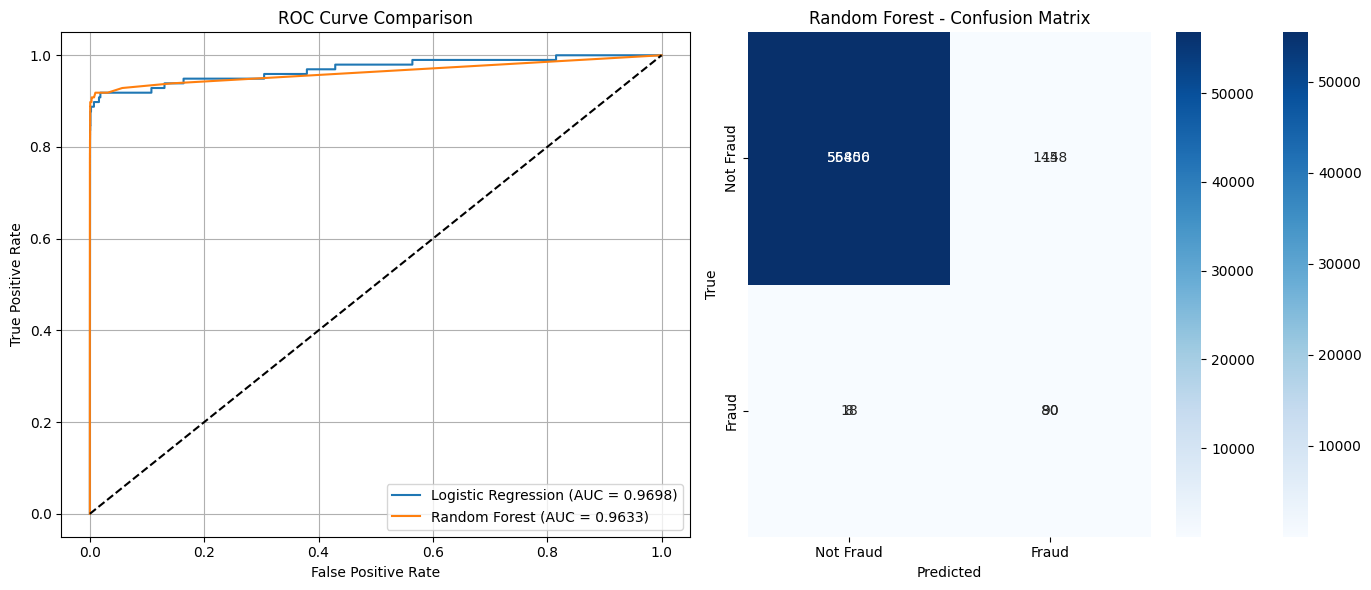

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# Load data from a CSV file into a pandas DataFrame
df = pd.read_csv("7. Predict Credit Card Fraud.csv")

# Separate features (X) and the target label (y)
X = df.drop(columns=['Class'])  # All columns except 'Class' are features
y = df['Class']  # 'Class' column is the target

# Scale 'Time' and 'Amount' features to normalize them
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split data into training and testing sets (80% train, 20% test), while preserving class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to oversample the minority class in the training data to balance class distribution
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the machine learning models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model on the resampled training set
    model.fit(X_train_res, y_train_res)

    # Predict class labels on the test set
    y_pred = model.predict(X_test)

    # Predict probabilities for the positive class (fraud) on the test set
    y_proba = model.predict_proba(X_test)[:, 1]

    # Generate classification report to evaluate model performance
    report = classification_report(y_test, y_pred, output_dict=True)

    # Compute the ROC AUC score
    auc = roc_auc_score(y_test, y_proba)

    # Generate confusion matrix to evaluate classification performance
    cm = confusion_matrix(y_test, y_pred)

    # Store the results for each model
    results[name] = {
        "report": report,
        "auc": auc,
        "confusion_matrix": cm,
        "fpr_tpr": roc_curve(y_test, y_proba)
    }

# Plot ROC Curves and Confusion Matrices for comparison
plt.figure(figsize=(14, 6))

# ROC Curve comparison
plt.subplot(1, 2, 1)
for name, result in results.items():
    fpr, tpr, _ = result["fpr_tpr"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc']:.4f})")

# Plot a diagonal line representing random classifier
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)

# Confusion Matrix heatmap
plt.subplot(1, 2, 2)
for name, result in results.items():
    cm = result["confusion_matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')

# Adjust layout and show plots
plt.tight_layout()
plt.show()
